In [1]:
import datetime as dt

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
import seaborn as sns
import tqdm
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils.scaler import STMatrixStandardScaler
from utils.helper import format_stmatrix, train_test_split
from dataset import STDataset
from trainer import Trainer
from logger import Logger

In [2]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=3)

## 前処理してデータセットを作成
- 渋滞量 -> フラグに変換
- 方向 -> 0/1に変換
    - 上り: 0, 下り: 1
- 四半期を数値化
- 使用しないカラムを落とす
    - 天気 + `index`, `data`, `road_code`, `jam_type`
- 速度の欠損を埋める
- OCC -> [0, 1]に変換
- 型変換
    - float64 -> float32
    - 区間の名前, コード, 県コードをcategoryデータに
    - degreeをint32
    - 0/1系をint32

In [365]:
col_types = {'start_code': str, 'end_code': str, 'road_code': str, 'jam_type': str,}

df = pd.read_csv(TRAFFIC_CSV, parse_dates=True, index_col='datetime', dtype=col_types).reset_index()

In [368]:
def linear_interpolate(df, col):
    '''
    dfのcolカラム内の欠損を区間ごとに線形補間する
    '''
    f = lambda g: g.interpolate(method='linear', axis=0)
    
    df.sort_values('datetime', inplace=True)
    df[col] = df.groupby(['start_code', 'end_code'])[col].apply(f)
    return df


def preprocess(df):
    # 「年」情報を入れる
    df['year'] = df['datetime'].dt.year
    # 渋滞フラグ 0/1
    df['jam_quantity'] = np.where(df['speed'] < 40, 1, 0)
    # 方向を数値化
    direction_map = {'上り': 0, '下り': 1}
    df['direction'] = df['direction'].map(direction_map)
    # 四半期を数値化
    df['quarter'] = df['quarter'].str[-1]
    
    # object型のカラム, いらないカラムを落とす
    drop_cols = [
        'index', 'date', 'road_code', 'pressure', 'rainfall', 
        'temperature', 'humidity', 'wind_speed', 'daylight_hours', 
        'snowfall', 'deepest_snowfall', 'weather_description', 'jam_type'
    ]
    df.drop(drop_cols, axis=1, inplace=True)
    
    # 速度の欠損を埋める
    df = linear_interpolate(df, 'speed')
    # OCCを[0,1]に変換
    df['OCC'] = df['OCC'] / 100.0
    
    # 型変換
    f64_cols = df.select_dtypes(include=[np.float64]).columns
    df.loc[:, f64_cols] = df.loc[:, f64_cols].astype(np.float32)
    i64_cols = df.select_dtypes(include=[int]).columns
    df.loc[:, i64_cols] = df.loc[:, i64_cols].astype(np.int32)
    
    type_map = {
        'start_name': 'category',
        'end_name': 'category',
        'start_code': 'category',
        'end_code': 'category',
        'start_pref_code': 'category',
        'end_pref_code': 'category',
        'start_degree': np.int32,
        'end_degree': np.int32,
        'degree_sum': np.int32,
        'direction': np.int32,
        'quarter': np.int32,
        'jam_quantity': np.int32,
    }
    df = df.astype(type_map)
    
    return df

In [4]:
def create_dataset(df, start_date, end_date, pkl_name):
    tmp = df.loc[(df['datetime'] >= pd.Timestamp(start_date)) & (df['datetime'] < pd.Timestamp(end_date))]
    # tmp.reset_index(drop=True, inplace=True)
    
    tmp = preprocess(tmp.copy())
    tmp.reset_index(drop=True, inplace=True)
    
    tmp.to_pickle(pkl_name)
    

# whole dataset
# start_date = '2021/5/1'
# end_date = '2022/6/1'
# pkl_name = './datasets/kannetsu_210501-220601.pkl'

# create_dataset(df, start_date, end_date, pkl_name)

# mini dataset
# start_date = '2021/5/1'
# end_date = '2021/6/1'
# pkl_name = './datasets/kannetsu_210501-210601.pkl'

# create_dataset(df, start_date, end_date, pkl_name)

## データセットを読み込む

In [3]:
# mini
df_test = pd.read_pickle('./datasets/kannetsu_210501-210601.pkl')

# whole
df_all = pd.read_pickle('./datasets/kannetsu_210501-220601.pkl')

In [4]:
df_test.head(3)

,datetime,start_name,end_name,start_code,end_code,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,...,search_unspec_10d,minute_quarter,allCars,jam_quantity,search_15min,OCC,speed,year,datetime_id,section_id
0,2021-05-01,所沢,大泉ＪＣＴ,1800006,1110210,11,13,35.806149,35.755821,139.535507,...,18949.0,0,211.0,0,6.0,0.023333,91.289101,2021,1162,31
1,2021-05-01,小出,大和ＰＡ,1800156,1800151,15,15,37.213329,37.160999,138.975403,...,7059.0,0,23.0,0,1.0,0.000000,94.869568,2021,1162,4
2,2021-05-01,六日町,塩沢石打,1800146,1800141,15,15,37.077942,36.990280,138.879288,...,6888.0,0,26.0,0,1.0,0.000000,91.961540,2021,1162,5


## Spatial Temporal Matrixに整形
- 区間数 x 時系列数 の行列
- 実際は 区間数 x 時系列数 x 特徴量数 のテンソル

In [5]:
# 特徴量の元になる列
# time_col = ['month', 'hour', 'dayofweek', 'is_holiday']
# section_col = ['direction', 'lane_count', 'KP']
time_col = ['datetime_id']
section_col = ['section_id']
search_col = ['search_15min', 'search_unspec_1d']
traffic_col = ['allCars']

feature_col = time_col + section_col + search_col + traffic_col
# feature_col = time_col + section_col + traffic_col
# feature_col = search_col + traffic_col

# 予測対象
target_col = 'allCars'

In [6]:
# 区間情報を管理するためのテーブルを作成
# sec_table = df_test[['start_name', 'end_name', 'direction', 'KP']].drop_duplicates()
# 区間順にソート
# sort_f = lambda g: g.sort_values('KP', ascending=(g.name == 1))
# sec_table = sec_table.groupby('direction').apply(sort_f).reset_index(drop=True)

# sec_table.head(3)

sec_table = pd.read_pickle('./datasets/section_table.pkl')

In [145]:
X, y = format_stmatrix(df_all, sec_table, feature_col, target_col)

## 標準化・正規化
- 標準化を行う
- 時間特徴量（`month`, `hour`, `day_of_week`）はsin, cosで変換するのもやってみる
- 検索数, 台数は上り・下り別でもやってみる

In [146]:
scaler = STMatrixStandardScaler()
scaler.fit(X)
X_norm = scaler.transform(X)

In [147]:
test_ratio = 0.2
X_train, X_val, y_train, y_val = train_test_split(X_norm, y, test_ratio)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

torch.Size([63, 30413, 5]) torch.Size([63, 30413, 1])
torch.Size([63, 7603, 5]) torch.Size([63, 7603, 1])


## データセットの定義

In [148]:
time_step = 96
prediction_horizon = 1
space_window = (-2, 2)

dataset_train = STDataset(X_train, y_train, time_step=time_step, prediction_horizon=prediction_horizon, space_window=space_window)
dataset_valid = STDataset(X_val, y_val, time_step=time_step, prediction_horizon=prediction_horizon, space_window=space_window)

## ネットワークの定義

In [144]:
tmp = dataset_train[:256][0]
tmp = tmp.permute(0, 2, 3, 1)
tmp.shape

torch.Size([256, 5, 5, 96])

In [107]:
conv1 = nn.Conv2d(1, 16, 3, padding=(0,1))
conv2 = nn.Conv2d(16, 8, 3, padding=(0,1))
lstm = nn.LSTM(8, 32, 1, batch_first=True)

In [114]:
lstm(conv2(conv1(tmp[:, -1:]))[:, :, 0, :].permute(0, 2, 1))[1][0][0].shape

torch.Size([256, 32])

In [90]:
conv1 = nn.Conv2d(2, 32, 3, padding=(0,1))
conv2 = nn.Conv2d(32, 16, 3, padding=(0,1))
fc = nn.Linear(16*96, 64)

In [94]:
fc(conv2(conv1(tmp[:, -3:-1])).view(256, -1)).shape

torch.Size([256, 64])

In [15]:
class Net(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers, batch_first=True):
        super().__init__()
        
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(in_dim, hid_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hid_dim, out_dim)
    
    def forward(self, x):
        outs, (h, c) = self.lstm(x)
        out = self.fc(h[0])
        return out
    

class SimpleNet(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers, batch_first=True):
        super().__init__()
        
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.num_layers = num_layers
        
        self.traffic_lstm = nn.LSTM(1, hid_dim, num_layers, batch_first=batch_first)
        self.search_lstm = nn.LSTM(2, hid_dim, num_layers, batch_first=batch_first)
        self.fc = nn.Linear(hid_dim * 2, out_dim)
        
    def forward(self, x):
        _, (traffic_h, _) = self.traffic_lstm(x[..., -1:])
        _, (search_h, _) = self.search_lstm(x[..., -3:-1])
        out = torch.cat([traffic_h[0], search_h[0]], dim=1)
        out = self.fc(out)
        return out
    

class SimpleNetWithoutQuery(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers, batch_first=True):
        super().__init__()
        
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.num_layers = num_layers
        
        self.traffic_lstm = nn.LSTM(1, hid_dim, num_layers, batch_first=batch_first)
        self.fc = nn.Linear(hid_dim, out_dim)
        
    def forward(self, x):
        _, (traffic_h, _) = self.traffic_lstm(x[..., -1:])
        out = self.fc(traffic_h[0])
        return out
    
    
class HA(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        out = x[..., -1:].mean(dim=1)
        return out
    

class ConvLSTM(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, kernel_size, num_layers=1, batch_first=True):
        super().__init__()
        
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        
        self.traffic_conv = nn.Conv1d(in_dim, in_dim, kernel_size)
        self.search_spec_conv = nn.Conv1d(in_dim, in_dim, kernel_size)
        self.search_unspec_conv = nn.Conv1d(in_dim, in_dim, kernel_size)
        
        self.traffic_lstm = nn.LSTM(1, hid_dim, num_layers, batch_first=batch_first)
        self.search_lstm = nn.LSTM(2, hid_dim, num_layers, batch_first=batch_first)
        
        self.fc = nn.Linear(hid_dim * 2, out_dim)
    
    def forward(self, x):
        # conv1d
        trf_out = self.traffic_conv(x[..., -1, :])
        spec_out = self.search_spec_conv(x[..., -3, :])
        unspec_out = self.search_unspec_conv(x[..., -2, :])
        search_out = torch.cat([spec_out, unspec_out], dim=2)
        # lstm
        _, (traffic_h, _) = self.traffic_lstm(trf_out)
        _, (search_h, _) = self.search_lstm(search_out)
        out = torch.cat([traffic_h[0], search_h[0]], dim=1)
        out = self.fc(out)
        return out
    

class ConvLSTMWithoutQuery(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, kernel_size, num_layers=1, batch_first=True):
        super().__init__()
        
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        
        self.traffic_conv = nn.Conv1d(in_dim, in_dim, kernel_size)
        self.traffic_lstm = nn.LSTM(1, hid_dim, num_layers, batch_first=batch_first)
        self.fc = nn.Linear(hid_dim, out_dim)
    
    def forward(self, x):
        # conv1d
        out = self.traffic_conv(x[..., -1, :])
        # lstm
        _, (traffic_h, _) = self.traffic_lstm(out)
        out = self.fc(traffic_h[0])
        return out

In [ ]:
class Conv1dLSTM(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, kernel_size, num_layers=1, batch_first=True):
        super().__init__()
        
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        
        self.traffic_conv = nn.Conv1d(in_dim, in_dim, kernel_size)
        self.search_spec_conv = nn.Conv1d(in_dim, in_dim, kernel_size)
        self.search_unspec_conv = nn.Conv1d(in_dim, in_dim, kernel_size)
        
        self.traffic_lstm = nn.LSTM(1, hid_dim, num_layers, batch_first=batch_first)
        self.search_lstm = nn.LSTM(2, hid_dim, num_layers, batch_first=batch_first)
        
        self.fc = nn.Linear(hid_dim * 2, out_dim)
    
    def forward(self, x):
        # conv1d
        trf_out = self.traffic_conv(x[..., -1, :])
        spec_out = self.search_spec_conv(x[..., -3, :])
        unspec_out = self.search_unspec_conv(x[..., -2, :])
        search_out = torch.cat([spec_out, unspec_out], dim=2)
        # lstm
        _, (traffic_h, _) = self.traffic_lstm(trf_out)
        _, (search_h, _) = self.search_lstm(search_out)
        out = torch.cat([traffic_h[0], search_h[0]], dim=1)
        out = self.fc(out)
        return out

In [140]:
class Conv2dLSTM(nn.Module):
    def __init__(self, hid_dim, kernel_size, num_layers=1, batch_first=True):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.padding = (0, 1)
        
        self.conv1 = nn.Conv2d(1, 16, 3, padding=self.padding)
        self.conv2 = nn.Conv2d(16, 8, 3, padding=self.padding)
        self.lstm = nn.LSTM(8, hid_dim, num_layers, batch_first=batch_first)
        
        self.search_conv1 = nn.Conv2d(2, 32, 3, padding=self.padding)
        self.search_conv2 = nn.Conv2d(32, 16, 3, padding=self.padding)
        self.search_fc = nn.Linear(16 * 96, 64)
        
        self.fc1 = nn.Linear(hid_dim + 64, 16)
        self.fc2 = nn.Linear(16, 1)
    
    def forward(self, x):
        # N x D x S x T
        x = x.permute(0, 2, 3, 1)
        N, D, S, T = x.shape
        
        # traffic
        out = F.relu(self.conv1(x[:, -1:]))
        out = F.relu(self.conv2(out))
        out = out[:, :, 0].permute(0, 2, 1)
        outs, (h, c) = self.lstm(out)
        
        # search feature
        s_out = F.relu(self.search_conv1(x[:, -3:-1]))
        s_out = F.relu(self.search_conv2(s_out))
        s_out = s_out.view(N, -1)
        s_out = F.relu(self.search_fc(s_out))
        
        # predict
        out = torch.cat([h[0], s_out], dim=1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        
        return out

## 学習

In [149]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

### HA

In [123]:
# HA
test_ratio = 0.2
X_train, X_val, y_train, y_val = train_test_split(X, y, test_ratio)

time_step = 96
prediction_horizon = 1
space_window = None

dataset_train = STDataset(X_train, y_train, time_step=time_step, prediction_horizon=prediction_horizon)
dataset_valid = STDataset(X_val, y_val, time_step=time_step, prediction_horizon=prediction_horizon)

batch_size = 256

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

torch.Size([256, 96, 10]) torch.Size([256, 1])


In [127]:
loss_fn = nn.L1Loss()

total_loss = 0.0
for i_batch, (data, target) in enumerate(train_loader):
    out = data[..., -1:].mean(dim=1)
    loss = loss_fn(out, target)

    total_loss += loss.item()

total_loss /= len(train_loader)
print(total_loss)

119.40930485210923


In [131]:
loss_fn = nn.L1Loss()

total_loss = 0.0
for i_batch, (data, target) in enumerate(val_loader):
    out = data[..., -1:].mean(dim=1)
    loss = loss_fn(out, target)

    total_loss += loss.item()

total_loss /= len(val_loader)
print(total_loss)

123.29348941637582


---
### LSTM

In [33]:
n_epochs = 50
in_dim = time_step
hid_dim = 32
out_dim = 1
kernel_size = 3
num_layers = 1

# model = Net(in_dim, hid_dim, out_dim, num_layers).to(device=device)
# model = SimpleNet(in_dim, hid_dim, out_dim, num_layers).to(device=device)
model = ConvLSTM(in_dim, hid_dim, out_dim, kernel_size, num_layers).to(device=device)
# model = ConvLSTMWithoutQuery(in_dim, hid_dim, out_dim, kernel_size, num_layers).to(device=device)
optimizer = optim.Adam(model.parameters())

loss_fn = nn.L1Loss()

log_path = './logs/ConvLSTM_traffic+search.log'
logger = Logger(fname=log_path)
trainer = Trainer(model, optimizer, loss_fn, device=device, logger=logger)

In [27]:
# model_path = './models/simpleLSTM_150.pth'
# model.load_state_dict(torch.load(model_path))

In [34]:
train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, n_epochs, log_steps=10, max_first_log_steps=5)

2022-08-08 06:03:32.031882 | Epoch: 1 | Train Loss: 122.698, Train Time: 65.28 [sec] | Valid Loss: 70.289, Valid Time: 6.79 [sec]
2022-08-08 06:04:43.056528 | Epoch: 2 | Train Loss: 44.531, Train Time: 64.20 [sec] | Valid Loss: 34.577, Valid Time: 6.83 [sec]
2022-08-08 06:05:53.505415 | Epoch: 3 | Train Loss: 25.821, Train Time: 63.61 [sec] | Valid Loss: 24.821, Valid Time: 6.84 [sec]
2022-08-08 06:07:03.973257 | Epoch: 4 | Train Loss: 19.964, Train Time: 63.63 [sec] | Valid Loss: 20.515, Valid Time: 6.84 [sec]
2022-08-08 06:08:15.258552 | Epoch: 5 | Train Loss: 17.566, Train Time: 64.44 [sec] | Valid Loss: 18.391, Valid Time: 6.84 [sec]
2022-08-08 06:14:10.764350 | Epoch: 10 | Train Loss: 15.771, Train Time: 63.80 [sec] | Valid Loss: 17.166, Valid Time: 6.83 [sec]
2022-08-08 06:25:59.046837 | Epoch: 20 | Train Loss: 15.291, Train Time: 64.32 [sec] | Valid Loss: 16.533, Valid Time: 6.84 [sec]
2022-08-08 06:37:47.064140 | Epoch: 30 | Train Loss: 15.080, Train Time: 64.05 [sec] | Valid L

In [42]:
train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, 10, log_steps=10, max_first_log_steps=5)

2022-08-08 10:28:50.095515 | Epoch: 90 | Train Loss: 14.569, Train Time: 66.72 [sec] | Valid Loss: 16.427, Valid Time: 7.20 [sec]


### Conv2d + LSTM

In [150]:
# hyper parameters
n_epochs = 40
hid_dim = 32
kernel_size = 3
num_layers = 1

# path
log_path = './logs/Conv2d+LSTM.log'

# model
model = Conv2dLSTM(hid_dim, kernel_size).to(device=device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.L1Loss()

logger = Logger(fname=log_path)
trainer = Trainer(model, optimizer, loss_fn, device=device, logger=logger)

In [151]:
train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, n_epochs, log_steps=10, max_first_log_steps=5)

2022-08-10 07:01:44.076587 | Epoch: 1 | Train Loss: 28.308, Train Time: 71.22 [sec] | Valid Loss: 17.885, Valid Time: 7.31 [sec]
2022-08-10 07:03:04.730491 | Epoch: 2 | Train Loss: 16.311, Train Time: 73.33 [sec] | Valid Loss: 17.345, Valid Time: 7.32 [sec]
2022-08-10 07:04:25.411244 | Epoch: 3 | Train Loss: 15.894, Train Time: 73.38 [sec] | Valid Loss: 16.594, Valid Time: 7.30 [sec]
2022-08-10 07:05:45.800508 | Epoch: 4 | Train Loss: 15.622, Train Time: 73.10 [sec] | Valid Loss: 16.900, Valid Time: 7.29 [sec]
2022-08-10 07:07:06.283341 | Epoch: 5 | Train Loss: 15.439, Train Time: 73.18 [sec] | Valid Loss: 16.358, Valid Time: 7.30 [sec]
2022-08-10 07:13:49.247264 | Epoch: 10 | Train Loss: 14.729, Train Time: 73.44 [sec] | Valid Loss: 15.766, Valid Time: 7.28 [sec]
2022-08-10 07:27:08.291624 | Epoch: 20 | Train Loss: 13.967, Train Time: 72.34 [sec] | Valid Loss: 15.183, Valid Time: 7.40 [sec]
2022-08-10 07:40:19.265830 | Epoch: 30 | Train Loss: 13.648, Train Time: 72.14 [sec] | Valid Lo

In [ ]:
train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, 30, log_steps=10, max_first_log_steps=5)

2022-08-10 08:21:31.285247 | Epoch: 50 | Train Loss: 13.263, Train Time: 70.94 [sec] | Valid Loss: 14.986, Valid Time: 7.29 [sec]


In [153]:
model_path = f'./models/Conv2d+LSTM_traffic_{trainer.current_epoch}.pth'
torch.save(model.state_dict(), model_path)

### 学習曲線

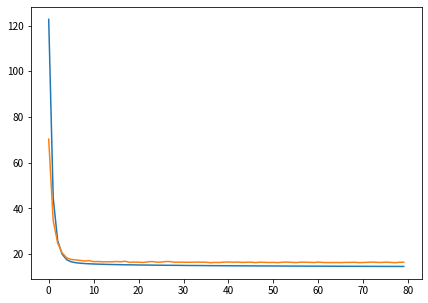

In [41]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(range(len(trainer.train_losses)), trainer.train_losses)
ax.plot(range(len(trainer.val_losses)), trainer.val_losses)
plt.show()

In [31]:
print(trainer.validate(train_loader))
print(trainer.validate(val_loader))

13.47916495185974
15.144232905007959


In [38]:
model_path = f'./models/mini_ConvLSTM_traffic_{trainer.current_epoch}.pth'
torch.save(model.state_dict(), model_path)

## 予測結果

In [33]:
start_date = pd.Timestamp('2022/5/1') - dt.timedelta(minutes=15) * time_step
end_date = pd.Timestamp('2022/5/9') - dt.timedelta(minutes=15)

In [52]:
S = sec_table.shape[0]
T = int((end_date - start_date).total_seconds() // (60 * 15))
D = len(feature_col)

X_test = torch.empty((S, T, D), dtype=torch.float32)
y_test = torch.empty((S, T, 1), dtype=torch.float32)

for sec_id, (s_name, e_name, *_) in sec_table.iterrows():
    query = f'start_name == "{s_name}" & end_name == "{e_name}"'
    df_sec = df_all.query(f'start_name == "{s_name}" & end_name == "{e_name}"')
    df_sec = df_sec[(df_sec['datetime'] >= start_date) & (df_sec['datetime'] < end_date)]
    
    data = df_sec.loc[:, feature_col].values
    target = df_sec.loc[:, target_col].values
    
    X_test[sec_id] = torch.from_numpy(data)
    y_test[sec_id, :, 0] = torch.from_numpy(target)
    
X_test = scaler.transform(X_test)

dataset_test = STDataset(X_test, y_test, time_step=time_step, prediction_horizon=prediction_horizon)

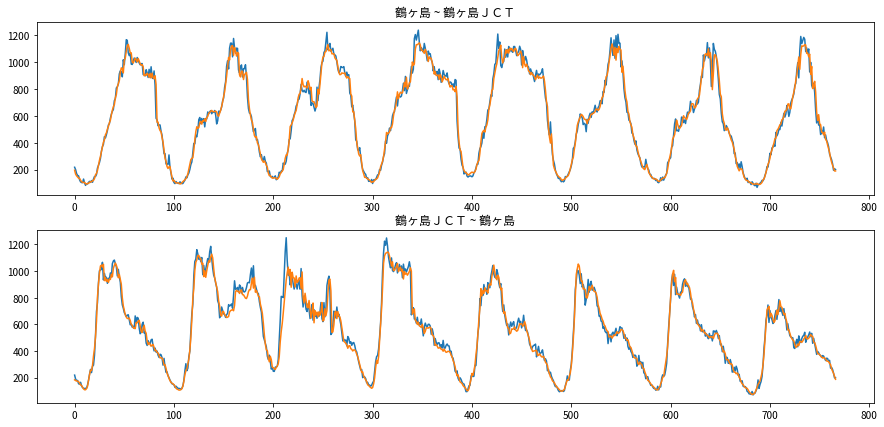

In [53]:
data = dataset_test[:][0].to(device=device)

with torch.no_grad():
    pred = model(data)

pred = pred.view(S, -1).to(device='cpu')
target = dataset_test[:][1].view(S, -1).to(device='cpu')

plot_sections = [27, 36]
fig, axes = plt.subplots(len(plot_sections), 1, figsize=(15, 7))
for i, sec_id in enumerate(plot_sections):
    axes[i].plot(target[sec_id], label='true')    
    axes[i].plot(pred[sec_id], label='pred')
    
    title = f'{sec_table.loc[sec_id, "start_name"]} ~ {sec_table.loc[sec_id, "end_name"]}'
    axes[i].set_title(title)

In [263]:
tmp_train = df_test[(df_test['start_name'] == '鶴ヶ島') & (df_test['direction'] == 1)]
tmp_train = tmp_train.loc[:, key_col + features]

# 時系列長
N_period = tmp_train.drop_duplicates("datetime").shape[0]
# 区間数
N_sec = tmp_train.drop_duplicates(["start_name", "end_name"]).shape[0]
# 特徴量数
D = len(features)

tmp_train_value = tmp_train[features].values.reshape(1, N_period, D)
tmp_train_norm = (tmp_train_value - X_mean) / X_std

In [264]:
tmp_X = []

for i in range(N_sec):
    for t in range(time_step, N_period - 24):
        time_pred = t + 24
        time_input = (t - time_step, t + time_step + 1)
        x_ = tmp_train_norm[i, time_input[0] : time_input[1]]
        tmp_X.append(x_)

tmp_X = torch.from_numpy(np.array(tmp_X, dtype=np.float32))

In [265]:
tmp_pred = model(tmp_X.to(device=device))

In [266]:
ys = np.arange(time_step, N_period - 24) + 24
tmp_y = tmp_train.iloc[ys, -1].values.reshape(-1, 1)
tmp_y = torch.from_numpy(tmp_y).to(device=device)

In [269]:
tmp_y[-10:]

tensor([[2830.],
        [2699.],
        [2518.],
        [2320.],
        [2056.],
        [1892.],
        [1657.],
        [1534.],
        [1343.],
        [ 890.]], device='cuda:0')

In [270]:
tmp_pred[-10:]

tensor([[1906.3523],
        [2111.0740],
        [1478.2659],
        [1709.9409],
        [1561.3125],
        [1184.2350],
        [1547.8439],
        [1354.0841],
        [ 719.4714],
        [ 688.2144]], device='cuda:0', grad_fn=<SliceBackward0>)

In [399]:
with torch.no_grad():
    i = 0
    for data, target in dataset_train:
        if i >= 10:
            break
        i += 1
        print(f'------- {i} -------')
        out = model(data.to(device=device))
        print(target)
        print(out)
        print(torch.sqrt(nn.functional.mse_loss(out, target.to(device=device))).item())
        print()

------- 1 -------
tensor(126.)
tensor([115.0645], device='cuda:0')
10.935508728027344

------- 2 -------
tensor(134.)
tensor([134.9498], device='cuda:0')
0.9497833251953125

------- 3 -------
tensor(170.)
tensor([168.9665], device='cuda:0')
1.0334625244140625

------- 4 -------
tensor(198.)
tensor([204.4083], device='cuda:0')
6.4083099365234375

------- 5 -------
tensor(179.)
tensor([184.3132], device='cuda:0')
5.313201904296875

------- 6 -------
tensor(202.)
tensor([209.7910], device='cuda:0')
7.79095458984375

------- 7 -------
tensor(224.)
tensor([240.2662], device='cuda:0')
16.266204833984375

------- 8 -------
tensor(317.)
tensor([303.8457], device='cuda:0')
13.154327392578125

------- 9 -------
tensor(383.)
tensor([374.0816], device='cuda:0')
8.918426513671875

------- 10 -------
tensor(440.)
tensor([439.5305], device='cuda:0')
0.469482421875



/tmp/ipykernel_65/1850680170.py:11: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print(torch.sqrt(nn.functional.mse_loss(out, target.to(device=device))).item())


In [339]:
n_epochs = 3000
in_dim = X_train.shape[-1]
hid_dim = 100
out_dim = 1
num_layers = 1

model = Net(in_dim, hid_dim, out_dim, num_layers).to(device=device)
optimizer = optim.Adam(model.parameters())

loss_fn = nn.MSELoss()

losses = []

for epoch in range(n_epochs):
    total_loss = 0
    for data, target in train_loader:
        data = data.to(device=device)
        target = target.unsqueeze(1).to(device=device)
        
        out = model(data)
        loss = loss_fn(out, target)
        total_loss += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses.append(total_loss)

    if epoch < 3 or (epoch + 1) % 100 == 0:
        print(f'{dt.datetime.now()} | Epoch {epoch+1} | Loss: {loss}')

2022-07-21 17:24:34.155558 | Epoch 1 | Loss: 65953.34375
2022-07-21 17:24:40.475783 | Epoch 2 | Loss: 6871.1943359375
2022-07-21 17:24:46.874386 | Epoch 3 | Loss: 11021.1640625


KeyboardInterrupt: 